# Pedestrian simulations

Here, we provide extra information regarding the pedestrian simulations we made. 

In [1]:
import numpy as onp

from jax import config ; config.update('jax_enable_x64', True)
import jax.numpy as np
from jax import random
from jax import jit
from jax import vmap
from jax import lax

vectorize = np.vectorize

from functools import partial

from collections import namedtuple
import base64

import IPython
from IPython.display import HTML, display
import time

import os

from jax_md import space, smap, energy, minimize, quantity, simulate, partition, util
from jax_md.util import f32

import ffmpeg

# Plotting

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as ani
import seaborn as sns

In [9]:
from utils import init_goal_speed, ttc_force, normal, ttc_potential_fn, time_to_collide, _normalize_cap

First, we verify that the goal_speed initialization is correct i.e. it produces a Gaussian distribution of walking speeds, truncated to be within one std of the mean. For our purposes, the distribution has mean 1.3 and std 0.3.

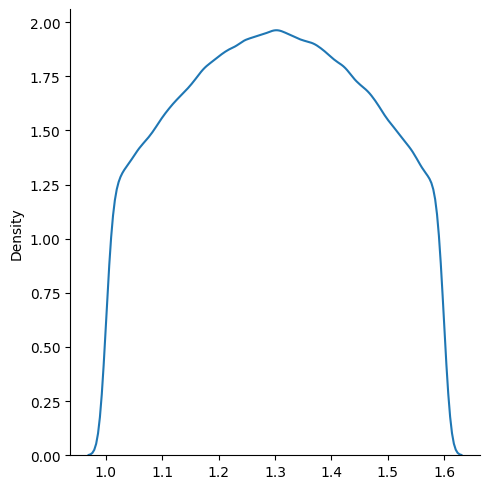

In [22]:
key = random.PRNGKey(69)
key, split = random.split(key)

goal_speeds = init_goal_speed(split, 1000000)
sns.displot(goal_speeds, kind='kde')

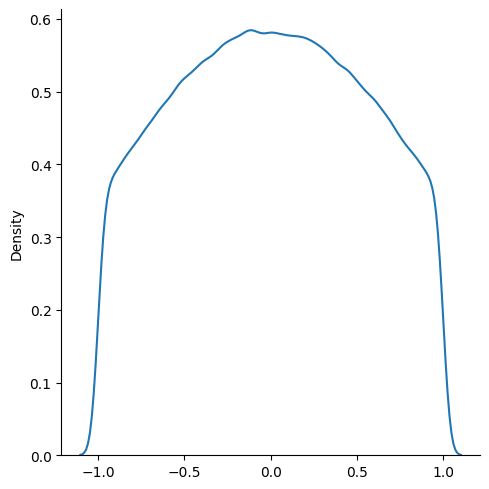

In [4]:
key, split = random.split(key)
distrib = random.truncated_normal(split, lower=-1, upper=+1, shape=(1000000,))
sns.displot(distrib, kind='kde')

Now, we graph the interaction force as a function of distance and approach velocity. According to the PowerLaw paper, the force has the following form:

$$\textbf{F}_{ij} = - \left[ \frac{ke^{-\tau / \tau_0}}{||\textbf{v}_{ij}||^2 \tau^2} \left(\frac{2}{\tau} + \frac{1}{\tau_0}\right) \right] \left[\textbf{v}_{ij} - \frac{||\textbf{v}_{ij}||^2 \textbf{x}_{ij} - (\textbf{x}_{ij} \cdot \textbf{v}_{ij})\textbf{v}_{ij}}{\sqrt{(\textbf{x}_{ij} \cdot \textbf{v}_{ij})^2 - ||\textbf{v}_{ij}||^2 (||\textbf{x}_{ij}||^2 - (R_i + R_j) ^ 2)}} \right] $$

To graph the force as a function of distance, we consider 2 pedestrians standing on the x-axis: The first pedestrian is stationary at (0, 0) while the second pedestrian is at (r, 0) and moving with speed 1. 

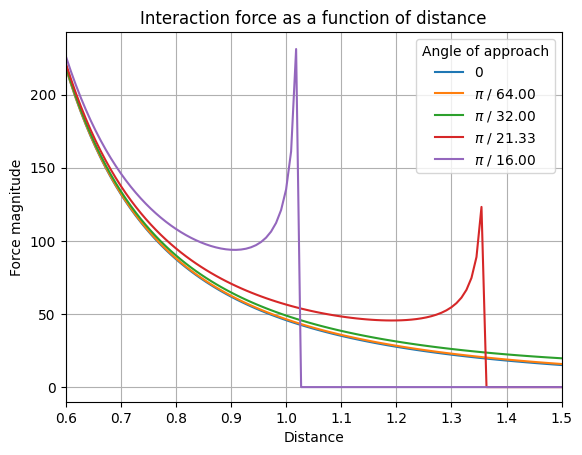

In [23]:
dposes = np.linspace(0.6, 1.5, 100)
angles = np.linspace(0, 1/16, 5)
V_1_mag = 1.
V_0 = np.array([0, 0])
R = 0.1

for angle in angles:
    V_1 = np.array([V_1_mag * np.cos(onp.pi * angle), V_1_mag * np.sin(onp.pi * angle)])
    force_mag = []
    for dpos in dposes:
        force_mag.append(np.linalg.norm(ttc_force(np.array([dpos, 0]), V_0, V_1, R, 1.5, 3.0)))
    plot_label = fr"$\pi$ / {1/angle:.2f}" if angle != 0 else fr"0"
    plt.plot(dposes, force_mag, label=plot_label)
plt.legend(title="Angle of approach")
plt.title("Interaction force as a function of distance")
plt.xlabel("Distance")
plt.ylabel("Force magnitude")
plt.xlim(0.6, 1.5)
plt.ylim(bottom=-10)
plt.grid()
plt.show()

In [ ]:
# dposes = np.linspace(0.6, 1.5, 100)
# angles = np.linspace(0, 1/16, 5)
# V_1_mag = 1.
# V_0 = np.array([0, 0])
# R = 0.1

# for angle in angles:
#     V_1 = np.array([V_1_mag * np.cos(onp.pi * angle), V_1_mag * np.sin(onp.pi * angle)])
#     force_mag = []
#     for dpos in dposes:
#         force_mag.append(np.linalg.norm(ttc_force(np.array([dpos, 0]), V_0, V_1, R, 1.5, 3.0)))
#     plot_label = fr"$\pi$ / {1/angle:.2f}" if angle != 0 else fr"0"
#     plt.plot(dposes, force_mag, label=plot_label)
# plt.legend(title="Angle of approach")
# plt.title("Interaction force as a function of distance")
# plt.xlabel("Distance")
# plt.ylabel("Force magnitude")
# plt.xlim(0.6, 1.5)
# plt.ylim(bottom=-10)
# plt.grid()
# plt.show()

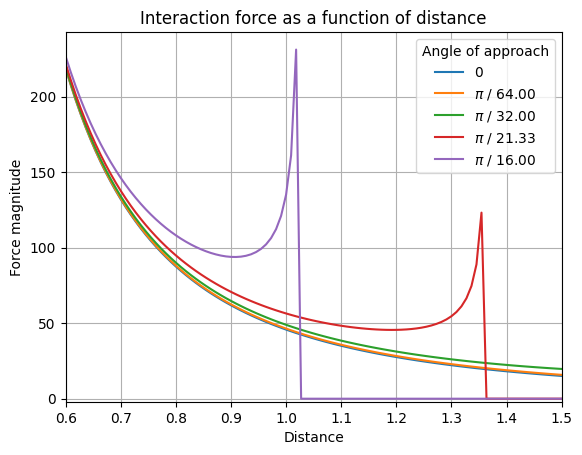

In [ ]:
k = 1.5
t0 = 3.0
m = 2

def dE(pa, pb, va, vb, ra, rb):
    global k,m,t0
    INFTY = 999
    maxt = 999

    w = pb - pa
    v = va - vb
    radius = ra+rb
    dist = np.sqrt(w[0]**2+w[1]**2)
    if radius > dist: radius = .99*dist
    a = np.dot(v, v)
    # IN ORIGINAL CODE: b = np.dot(w, v) ???
    b = -np.dot(w, v)
    c = np.dot(w, w) - radius*radius
    discr = b*b - a*c
    if (discr < 0) or (a<0.001 and a > - 0.001): return np.array([0, 0])
    discr = np.sqrt(discr)
    t1 = (b - discr) / a

    t = t1

    if (t < 0): return np.array([0, 0])
    if (t > maxt): return np.array([0, 0])

    d = k*np.exp(-t/t0)*(v - (v*b - w*a)/(discr))/(a*t**m)*(m/t+ 1/t0)

    return d

dposes = np.linspace(0.6, 1.5, 100)
angles = np.linspace(0, 1/16, 5)
V_1_mag = 1.
V_0 = np.array([0, 0])
R = 0.1

for angle in angles:
    V_1 = np.array([V_1_mag * np.cos(onp.pi * angle), V_1_mag * np.sin(onp.pi * angle)])
    force_mag = []
    for dpos in dposes:
        force_mag.append(np.linalg.norm(dE(np.array([0, 0]), np.array([dpos, 0]), V_0, V_1, R, R)))
    plot_label = fr"$\pi$ / {1/angle:.2f}" if angle != 0 else fr"0"
    plt.plot(dposes, force_mag, label=plot_label)
plt.legend(title="Angle of approach")
plt.title("Interaction force as a function of distance")
plt.xlabel("Distance")
plt.ylabel("Force magnitude")
plt.xlim(0.6, 1.5)
plt.ylim(bottom=-2)
plt.grid()
plt.show()

We compare the above force function to the energy function of the same system

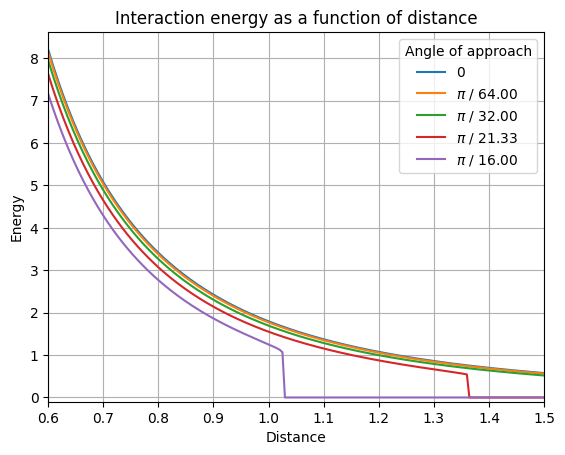

In [24]:
dposes = np.linspace(0.6, 1.5, 200)
angles = np.linspace(0, 1/16, 5)
V_1_mag = 1.
V_0 = np.array([0, 0])
R = 0.1

for angle in angles:
    V_1 = np.array([V_1_mag * np.cos(onp.pi * angle), V_1_mag * np.sin(onp.pi * angle)])
    energy = []
    for dpos in dposes:
        energy.append(ttc_potential_fn(1.5, time_to_collide(np.array([dpos, 0]), V_1, V_0, R), 3.0))
    plot_label = fr"$\pi$ / {1/angle:.2f}" if angle != 0 else fr"0"
    plt.plot(dposes, energy, label=plot_label)

plt.legend(title="Angle of approach")
plt.title("Interaction energy as a function of distance")
plt.xlabel("Distance")
plt.ylabel("Energy")
plt.xlim(0.6, 1.5)
plt.ylim(bottom=-0.1)
plt.grid()
plt.show()

Based on the graph of the interaction force and the interaction energy, we can deduce the cause of the 'spike' seen in the Force graph is due to the sudden drop in interaction energy. This drop in interaction energy occurs at the point where the trajectory of one pedestrian is tangent to the other, and at this point, the collision time suddenly transitions from a finite value (collision possible) to infinity (collision impossible). 

To avoid these irregularities in the force function, it is best to cap the value of the force function during simulations. In the original paper's simulations, the force's magnitude is capped at 5.0.

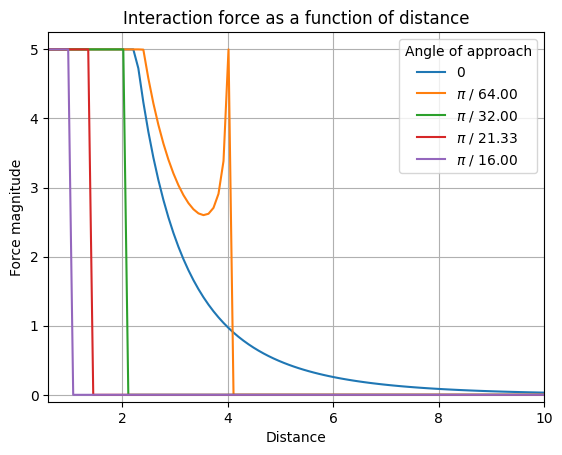

In [18]:
dposes = np.linspace(0.6, 10, 100)
angles = np.linspace(0, 1/16, 5)
V_1_mag = 1.
V_0 = np.array([0, 0])
R = 0.1

for angle in angles:
    V_1 = np.array([V_1_mag * np.cos(onp.pi * angle), V_1_mag * np.sin(onp.pi * angle)])
    force_mag = []
    for dpos in dposes:
        force = np.linalg.norm(ttc_force(np.array([dpos, 0]), V_0, V_1, R, 1.5, 3.0))
        force = np.where(force > 5.0, 5.0, force)
        force_mag.append(force)
    plot_label = fr"$\pi$ / {1/angle:.2f}" if angle != 0 else fr"0"
    plt.plot(dposes, force_mag, label=plot_label)
plt.legend(title="Angle of approach")
plt.title("Interaction force as a function of distance")
plt.xlabel("Distance")
plt.ylabel("Force magnitude")
plt.xlim(0.6, 10)
plt.ylim(bottom=-0.1)
plt.grid()
plt.show()